<b>installments_payments.csv</b>

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

<a id="top"></a>
- [Overview](#overview)
- [SK_ID_PREV](#sk-id-prev)
- [SK_ID_CURR](#sk-id-curr)
- [SK_ID_CURR & SK_ID_PREV](#sk-id-curr-sk-id-prev)
- [NUM_INSTALMENT_VERSION](#num-instalment-version)
- [NUM_INSTALMENT_NUMBER](#num-instalment-number)
- [DAYS_INSTALMENT](#days-instalment)
- [DAYS_ENTRY_PAYMENT](#days-entry-payment)
- [AMT_INSTALMENT](#amt-instalment)
- [AMT_PAYMENT](#amt-payment)

## Prepare

In [13]:
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 999

inp = feather.read_dataframe('../data/input/installments_payments.feather')
prv = feather.read_dataframe('../data/input/previous_application.feather')
app_trn = pd.read_feather('../data/input/application_train.feather')

def target_bar(df, col, title=None):

    df0 = df[df["TARGET"] == 0]
    df1 = df[df["TARGET"] == 1]

    t0 = df0[col].value_counts().rename(col + '0')
    t1 = df1[col].value_counts().rename(col + '1')
    t = pd.concat([t0, t1], axis=1).fillna(0).astype(int)
    t['total'] = t.sum(axis=1)
    t.sort_values('total', inplace=True, ascending=False)
    t.drop(columns=['total'], inplace=True)

    idx = np.arange(len(t))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    p1 = ax.bar(idx, t[col + '0'], width)
    p2 = ax.bar(idx+width, t[col + '1'], width)
    ax.legend((p1[0], p2[0]), ('Target=0', 'Target=1'))
    ax.set_title(title)
    ax.set_xticks(idx + width / 2)
    ax.set_xticklabels(t.index.values, rotation=45)

    plt.show()
    
def target_hist(df, col, title):

    df0 = df[df["TARGET"] == 0]
    df1 = df[df["TARGET"] == 1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.distplot(df0[col].dropna(), ax=axes[0], color='b')
    axes[0].set_title('Target=0')
    sns.distplot(df1[col].dropna(), ax=axes[1], color='orange')
    axes[1].set_title('Target=1')
    fig.suptitle(title)
    plt.show()

<a id='overview'></a>
## Overview

In [2]:
inp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [3]:
inp.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


<div style="text-align: right;">
[back to top](#top)
</div>

<a id='sk-id-prev'></a>
## SK_ID_PREV

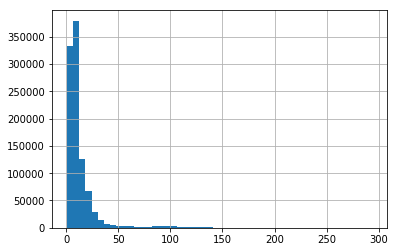

In [4]:
inp.groupby('SK_ID_PREV').size().hist(bins=50)

<div style="text-align: right;">
[back to top](#top)
</div>

<a id='sk-id-curr'></a>
## SK_ID_CURR

In [5]:
inp.groupby('SK_ID_CURR').size().describe()

count    339587.000000
mean         40.064552
std          41.053343
min           1.000000
25%          12.000000
50%          25.000000
75%          51.000000
max         372.000000
dtype: float64

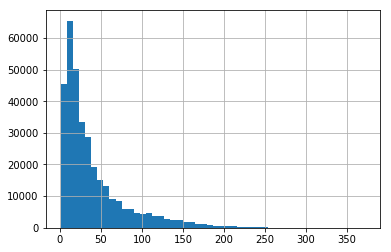

In [6]:
inp.groupby('SK_ID_CURR').size().hist(bins=50)

<div style="text-align: right;">
[back to top](#top)
</div>

<a id='sk-id-curr-sk-id-prev'></a>
## SK_ID_CURR & SK_ID_PREV

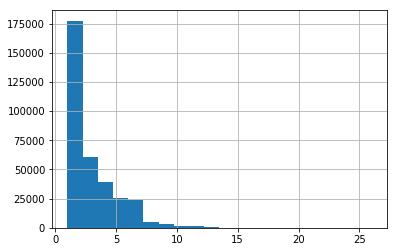

In [7]:
inp.groupby('SK_ID_CURR').SK_ID_PREV.nunique().hist(bins=20)

<div style="text-align: right;">
[back to top](#top)
</div>

<a id='num-instalment-version'></a>
## NUM_INSTALMENT_VERSION

Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed

installmentのバージョンを管理しているらしい
頻繁にinstallmentのカレンダーを変更している奴はやばいとかあるかもしれない

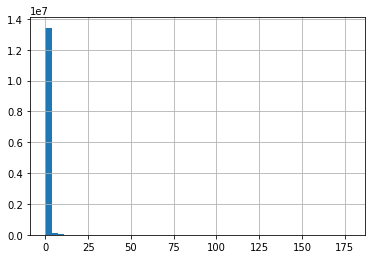

In [8]:
inp.NUM_INSTALMENT_VERSION.hist(bins=50)

変更回数 = NUM_INSTALMENT_VERSIONのユニーク数

In [9]:
cnt_instalment_ver = inp.groupby('SK_ID_PREV').agg({
    'SK_ID_CURR': pd.Series.unique,
    'NUM_INSTALMENT_VERSION': pd.Series.nunique,
})

In [10]:
cnt_instalment_ver = cnt_instalment_ver.groupby('SK_ID_CURR').sum()

In [11]:
cnt_instalment_ver = cnt_instalment_ver.reset_index()

In [14]:
cnt_instalment_ver = cnt_instalment_ver.merge(app_trn[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='right')

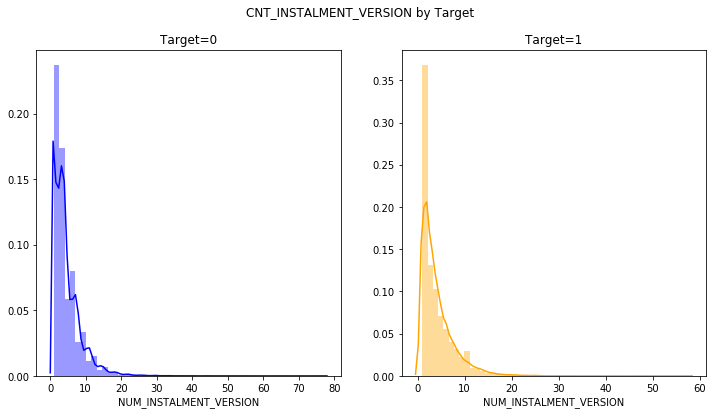

In [15]:
target_hist(cnt_instalment_ver, 'NUM_INSTALMENT_VERSION', 'CNT_INSTALMENT_VERSION by Target')

<div style="text-align: right;">
[back to top](#top)
</div>

<a id='num-instalment-number'></a>
## NUM_INSTALMENT_NUMBER

On which installment we observe payment

何回目の支払いか

In [16]:
inp.NUM_INSTALMENT_NUMBER.describe()

count    1.360540e+07
mean     1.887090e+01
std      2.666407e+01
min      1.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.900000e+01
max      2.770000e+02
Name: NUM_INSTALMENT_NUMBER, dtype: float64

In [17]:
inp.NUM_INSTALMENT_NUMBER.head()

0     6
1    34
2     1
3     3
4     2
Name: NUM_INSTALMENT_NUMBER, dtype: int64

In [18]:
num_inst_max = inp.groupby('SK_ID_PREV').agg({
    'SK_ID_CURR': pd.Series.unique,
    'NUM_INSTALMENT_NUMBER': 'max'
})

In [19]:
num_inst_max_sum = num_inst_max.groupby('SK_ID_CURR').sum().reset_index()
num_inst_max_sum = num_inst_max_sum.merge(app_trn[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='right')

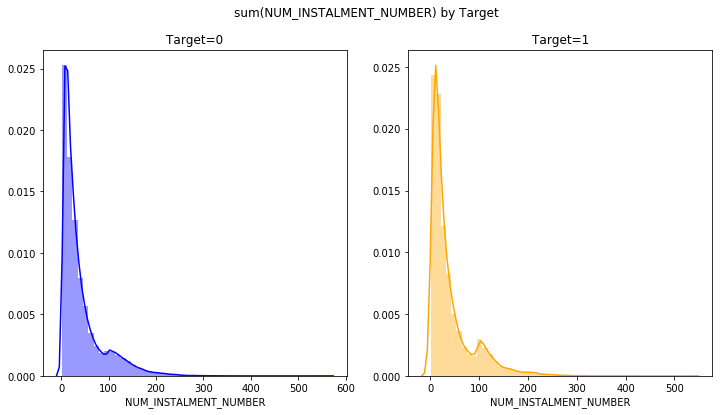

In [20]:
target_hist(num_inst_max_sum, 'NUM_INSTALMENT_NUMBER', 'sum(NUM_INSTALMENT_NUMBER) by Target')

<a id='days-instalment'></a>
## DAYS_INSTALMENT

When the installment of previous credit was supposed to be paid (relative to application date of current loan)


<a id='days-entry-payment'></a>
## DAYS_ENTRY_PAYMENT

When was the installments of previous credit paid actually (relative to application date of current loan)

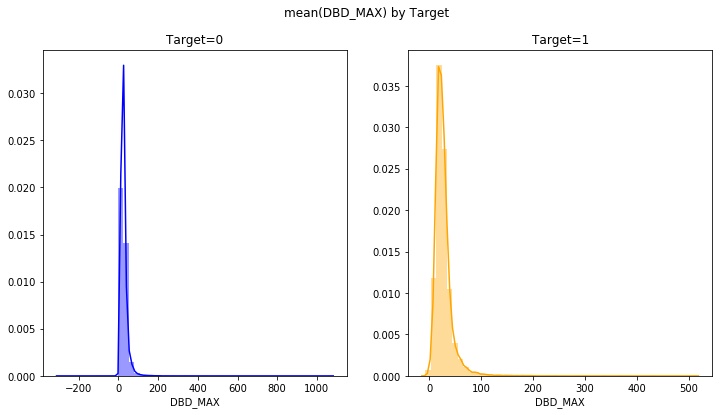

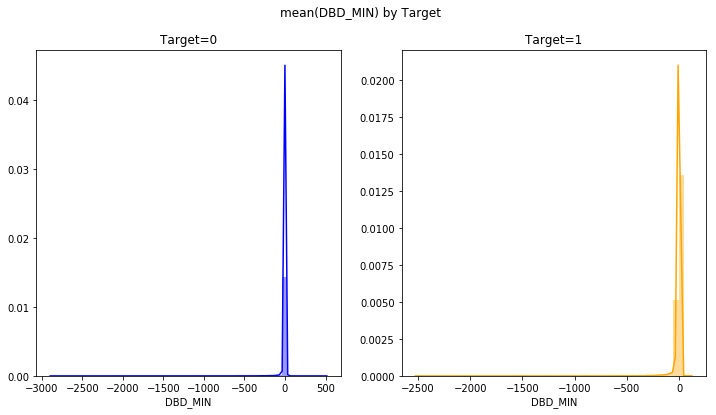

In [21]:
# Days Before Due date
inp['DBD'] = -(inp['DAYS_ENTRY_PAYMENT'] - inp['DAYS_INSTALMENT'])
dbd = inp.groupby('SK_ID_PREV').agg({
    'SK_ID_CURR': pd.Series.unique,
    'DBD': ['max', 'min']
})
dbd.columns = ['_'.join(col).strip() for col in dbd.columns.values]

dbd = dbd.rename(columns={
    'SK_ID_CURR_unique': 'SK_ID_CURR',
    'DBD_max': 'DBD_MAX',
    'DBD_min': 'DBD_MIN'
})
agg_dbd = dbd.groupby('SK_ID_CURR').mean().reset_index()
agg_dbd = agg_dbd.merge(
    app_trn[['SK_ID_CURR', 'TARGET']],
    on='SK_ID_CURR', how='right'
)
target_hist(agg_dbd, 'DBD_MAX', 'mean(DBD_MAX) by Target')
target_hist(agg_dbd, 'DBD_MIN', 'mean(DBD_MIN) by Target')

<a id='amt-instalment'></a>
## AMT_INSTALMENT

What was the prescribed installment amount of previous credit on this installment

In [22]:
inp[inp.SK_ID_PREV == inp.SK_ID_PREV.unique()[400]][[
    'SK_ID_PREV',
    'AMT_INSTALMENT',
    'NUM_INSTALMENT_NUMBER'
]].sort_values('NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,AMT_INSTALMENT,NUM_INSTALMENT_NUMBER
2681940,1887529,8518.86,1
1512957,1887529,8518.86,2
2814868,1887529,8518.86,3
760631,1887529,8518.86,4
1740900,1887529,8518.86,5
1130540,1887529,8518.86,5
3102450,1887529,8518.86,6
407,1887529,8518.86,6
120254,1887529,8518.86,7
3220701,1887529,8518.86,8


<a id='amt-instalment'></a>
## AMT_INSTALMENT

What was the prescribed installment amount of previous credit on this installment

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13605401 entries, 0 to 13605400
Data columns (total 9 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
TARGET                    float64

In [30]:
prv[prv.SK_ID_PREV == inp.SK_ID_PREV.unique()[123]][['AMT_APPLICATION','AMT_CREDIT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED']]

,AMT_APPLICATION,AMT_CREDIT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED
183894,185211.0,217971.0,NaN,NaN


In [29]:
inp[inp.SK_ID_PREV == inp.SK_ID_PREV.unique()[123]][[
    'SK_ID_PREV',
    'AMT_PAYMENT',
    'AMT_INSTALMENT',
    'NUM_INSTALMENT_NUMBER'
]].AMT_PAYMENT.sum()

235554.075